# WordNet dataset generation

In [1]:
from nltk.corpus import wordnet as wn
from collections import defaultdict

In [ ]:
def getDataForSynset(sname, fname):

    closure = defaultdict(set)

    def walk(node, ancestors):
        node_name = node.name()
        closure[node_name].update(ancestors)
        for s in node.hyponyms():
            walk(s, ancestors + [node_name])

    walk(wn.synset(sname), [sname])
    #Write out tsv
    with open(fname, 'w') as f:
        for n in closure:
            for a in closure[n]:
                f.write(n + '\t' + a + '\t' + "1\n")

In [ ]:
getDataForSynset('entity.n.01', "data/wordnet_nouns.tsv")

In [ ]:
getDataForSynset('mammal.n.01', "data/wordnet_mammals.tsv")

# Training

## Imports

In [6]:
import sys
import timeit
import gc
import logging
import argparse
import numpy as np
import torch as th
import torch.multiprocessing as mp
from torch.autograd import Variable
from collections import defaultdict as ddict
from sklearn.metrics import average_precision_score
from torch.utils.data import DataLoader

from model import LorentzEmbedding
from data import DatasetReader
from optimization import RiemannianSGD
from optimization import LorentzDistance

th.set_default_tensor_type(th.DoubleTensor)
# Decide which device we want to run on
ngpu = 1
device = th.device("cuda:0" if (th.cuda.is_available() and ngpu > 0) else "cpu")

## Helper functions

In [3]:
def evaluate(types, model):
    with th.no_grad():
        embs = th.from_numpy(model.embedding())
        embedding = Variable(embs)
        ranks = []
        ap_scores = []
        for s, tree in types.items():
            s_e = Variable(embs[s].unsqueeze(0))
            dists_curr = model.dist()(s_e, embedding).data.cpu().numpy().flatten()
            dists_curr[s] = 1e14
            labels = np.zeros(embedding.size(0))
            dists_masked = dists_curr.copy()
            ranks_curr = []
            
            for o in tree:
                dists_masked[o] = float('inf')
                labels[o] = 1 
            ap_scores.append(average_precision_score(labels, -dists_curr))
            for o in tree:
                d = dists_masked.copy()
                d[o] = dists_curr[o]
                r = np.argsort(d)
                ranks_curr.append(np.where(r == o)[0][0] + 1)
            ranks += ranks_curr
    return np.mean(ranks), np.mean(ap_scores)

## Constants

In [7]:
_lr_multiplier = 0.01                     #Burnin multiplier
dim = 5                                  #The dimensionality of the embdding
dataset = './data/wordnet_nouns.tsv'   #The dataset to learn
fout = './nouns.pth'                   #The output model file
lr_base = 1.0                            #The base learning rate
epochs = 1500                            #Max number of epochs
batchsize = 20                           #The batch size
negs = 50                                #Number of negative examples
eval_each = 10                           #The number of epochs between each evaluation
burnin = 20                              #The number of burnin epochs
nworkers = 5                             #The number of dataset readers

## Setup

In [5]:
#Dataset setup
data = DatasetReader(dataset, negs)
idx = data.samples

# create adjacency list for evaluation
adjacency = ddict(set)
for i in range(len(idx)):
    s, o, _ = idx[i]
    adjacency[s].add(o)
adjacency = dict(adjacency)

# initialize model and data
model = LorentzEmbedding(len(data.entities), dim, LorentzDistance).to(device)

# initialize optimizer
optimizer = RiemannianSGD(
    model.parameters(),
    lr=lr_base,
    device=device
)

## Training

In [6]:
min_rank = (float('inf'), -1)
max_map = (0, -1)
loader = DataLoader(
        data,
        batch_size=batchsize,
        shuffle=True,
        num_workers=nworkers,
        collate_fn=data.collate
    )

for epoch in range(epochs):
    epoch_loss = []
    loss = None
    data.burnin = False
    lr = lr_base
    t_start = timeit.default_timer()
    if epoch < burnin:
        data.burnin = True
        lr = lr_base * _lr_multiplier
        
    #Training loop
    for inputs, targets in loader:
        inputs = th.from_numpy(np.vstack(inputs)).to(device)
        targets = th.from_numpy(np.vstack(targets)).squeeze().to(device)

        elapsed = timeit.default_timer() - t_start
        optimizer.zero_grad()
        preds = model(inputs)
        loss = model.loss(preds, targets)
        loss.backward()
        optimizer.step(lr=lr)
        epoch_loss.append(loss.data[0])
#         th.save({
#            'model': model.state_dict(),
#            'epoch': epoch,
#            'entities': data.entities
#         }, 'run/%05d.pth'%epoch)
        
    #Evaluation
    if epoch == (epochs - 1) or epoch % eval_each == (eval_each - 1):
        th.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'entities': data.entities
            }, fout)
        mrank, mAP = evaluate(adjacency, model)
        if mrank < min_rank[0]:
            min_rank = (mrank, epoch)
        if mAP > max_map[0]:
            max_map = (mAP, epoch)
        print(
            ('epoch: %d, '
             'loss: %.3f, '
             'mean rank: %.2f, '
             'mAP: %.4f, '
             'best rank: %.2f, '
             'best mAP: %.4f, '
             'time: %.2fs') % (
                 epoch, loss, mrank, mAP, min_rank[0], max_map[0], elapsed)
        )

    gc.collect()

/home/dbw003/.conda/envs/jhubMachineLearning/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/dbw003/.conda/envs/jhubMachineLearning/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Process Process-2:
Process Process-3:
Process Process-1:
Process Process-5:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dbw003/.conda/envs/jhubMachineLearning/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dbw003/.conda/envs/jhubMachineLearning/lib/python3.6/multiprocessing/process.py", line 

KeyboardInterrupt: 

# Visualization

In [ ]:
model = th.load('./mammals.pth')
lorentz_embeddings = model['model']['embeddings.weight']
dim0 = lorentz_embeddings[:,0].unsqueeze(1)
dimn = lorentz_embeddings[:,1:]

poincare_embeddings = dimn / (dim0 + 1)

In [ ]:
links = defaultdict(set)
family_start = ['lynx.n.02']
for f in family_start:
    stack = [f]
    first = True
    while len(stack) > 0:
        v = stack.pop()
        for k in wn.synsets(v.split('.')[0]):
            if k.name() in model['entities']:
                for u in k.hypernyms():
                    if u.name() in model['entities']:                            
                        links[k.name()].add(u.name())
                        stack.append(u.name())

In [3]:
from torch.autograd import Function
#NOTE: The code in this cell originates from the ofiicial Poincare embeddings implementation
#https://github.com/facebookresearch/poincare-embeddings
eps = 1e-5
class Arcosh(Function):
    def __init__(self, eps=eps):
        super(Arcosh, self).__init__()
        self.eps = eps 

    def forward(self, x): 
        self.z = th.sqrt(x * x - 1)
        return th.log(x + self.z)

    def backward(self, g): 
        z = th.clamp(self.z, min=eps)
        z = g / z 
        return z

class PoincareDistance(Function):
    boundary = 1 - eps 

    def grad(self, x, v, sqnormx, sqnormv, sqdist):
        alpha = (1 - sqnormx)
        beta = (1 - sqnormv)
        z = 1 + 2 * sqdist / (alpha * beta)
        a = ((sqnormv - 2 * th.sum(x * v, dim=-1) + 1) / th.pow(alpha, 2)).unsqueeze(-1).expand_as(x)
        a = a * x - v / alpha.unsqueeze(-1).expand_as(v)
        z = th.sqrt(th.pow(z, 2) - 1)
        z = th.clamp(z * beta, min=eps).unsqueeze(-1)
        return 4 * a / z.expand_as(x)

    def forward(self, u, v): 
        self.save_for_backward(u, v)
        self.squnorm = th.clamp(th.sum(u * u, dim=-1), 0, self.boundary)
        self.sqvnorm = th.clamp(th.sum(v * v, dim=-1), 0, self.boundary)
        self.sqdist = th.sum(th.pow(u - v, 2), dim=-1)
        x = self.sqdist / ((1 - self.squnorm) * (1 - self.sqvnorm)) * 2 + 1 
        # arcosh
        z = th.sqrt(th.pow(x, 2) - 1)
        return th.log(x + z)

    def backward(self, g): 
        u, v = self.saved_tensors
        g = g.unsqueeze(-1)
        gu = self.grad(u, v, self.squnorm, self.sqvnorm, self.sqdist)
        gv = self.grad(v, u, self.sqvnorm, self.squnorm, self.sqdist)
        return g.expand_as(gu) * gu, g.expand_as(gv) * gv

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import animation, rc
from IPython.display import HTML, Image

from sklearn.decomposition import PCA
import glob
import time

rc('animation', html='html5')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim(( -1.1, 1.1))
ax.set_ylim((-1.1, 1.1))
ax.set_axis_off()

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ld = LorentzDistance()
pd = PoincareDistance()
s = [1 for n in range(len(model['entities']))]

links = {'lynx.n.02': {'feline.n.01'},
         'feline.n.01' : {'big_cat.n.01'},
         'big_cat.n.01': {'carnivore.n.01'},
         'carnivore.n.01': {'mammal.n.01'},
         'mammal.n.01': {}}
root = model['entities'].index('mammal.n.01')


In [ ]:
fig_items = []
circle, = ax.plot([], [], linewidth=1, color='black')
fig_items.append(circle)
x = []
y = []
t = np.linspace(0,np.pi*2,1000)
x.extend(list(np.cos(t)))
y.extend(list(np.sin(t)))

scatter = ax.scatter([], [], s=s, color='darkblue')
fig_items.append(scatter)

label_items = {}
link_items = defaultdict(dict)
for l in links:
    t = ax.text([], [], l, bbox=bbox_props, ha="center", va="center")
    fig_items.append(t)
    label_items[l] = t
    for n in links[l]:
        p, = ax.plot([], [], 'k-', lw=0.75)
        fig_items.append(p)
        link_items[l][n] = p

In [ ]:
def init():
    circle.set_data(x, y)
    return fig_items,

runfiles = list(sorted(glob.glob('./run/*.pth')))[:-1]   

def animate(i):
    model = th.load(runfiles[i])
    lorentz_embeddings = model['model']['embeddings.weight']
    dim0 = lorentz_embeddings[:,0].unsqueeze(1)
    dimn = lorentz_embeddings[:,1:]

    poincare_embeddings = dimn / (dim0 + 1)
    #pca = PCA(n_components=2)
    #reduced = pca.fit_transform(poincare_embeddings)
    reduced = poincare_embeddings
    circle.set_data(x, y)
    
    scatter.set_offsets(reduced)
    
    for l in links:
        start = model['entities'].index(l)
        dc = ld(lorentz_embeddings[root].unsqueeze(0), lorentz_embeddings[start].unsqueeze(0)).cpu().data.numpy()
        label = "%s; $d_r$: %.03f"%(l,dc)
        for t in links[l]:
            node = model['entities'].index(t)
            dp = ld(lorentz_embeddings[node].unsqueeze(0), lorentz_embeddings[start].unsqueeze(0)).cpu().data.numpy()
            #ax.text(reduced[node,0], reduced[node,1], lab, bbox=bbox_props, ha="center", va="center")
            link_items[l][t].set_data([reduced[start, 0], reduced[node, 0]], [reduced[start, 1], reduced[node, 1]])
            label += ";$d_p$: %.03f"%dp
        label_items[l].set_position([reduced[start,0], reduced[start,1]])
        label_items[l].set_text(label)

    return fig_items,

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(runfiles), interval=100, blit=True)
anim.save('./media/visualize.gif', writer='imagemagick', fps=10)

## Heatmap visualizations

In [79]:
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.decomposition import PCA
import glob
import time
import copy
from scipy.interpolate import griddata
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def draw_heatmap(point, save_file_name, title="Heatmap"):
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
    pd = PoincareDistance()

    rs = np.linspace(0.0, 1., 500)
    phis = np.linspace(0.0, 2*np.pi + 2*np.pi / 500, 500)
    phi_grid, r_grid = np.meshgrid(phis, rs)
    x, y = r_grid*np.cos(phi_grid), r_grid*np.sin(phi_grid)

    p = th.DoubleTensor(point).to(device)
    
    z = [[pd(p, th.DoubleTensor([xp,yp]).to(device)).cpu().data.numpy() for xp,yp in zip(xa,ya)] for xa,ya in zip(x,y)]

    z = np.asarray(z)
 
    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('jet')
    levels = MaxNLocator(nbins=cmap.N).tick_values(0, z.max())
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    plt.ion()

    # contours are *point* based plots, so convert our bound into point
    # centers

    dx = copy.copy(x)
    dx[:-1] = dx[1:] - dx[:-1]
    dx[-1] = dx[-1] - dx[-1]

    dy = copy.copy(y)
    dy[:, :-1] = dy[:, 1:] - dy[:, :-1]
    dy[:, -1] = dy[:, -1] - dy[:, -1]

    cf = ax.contourf(x + dx / 2.,
                      y + dy / 2., z, levels=levels,
                      cmap=cmap)
    fig.colorbar(cf, ax=ax)
    ax.set_axis_off()
    ax.set_title(title)

    plt.show()
    
    plt.savefig(save_file_name)

<IPython.core.display.Javascript object>


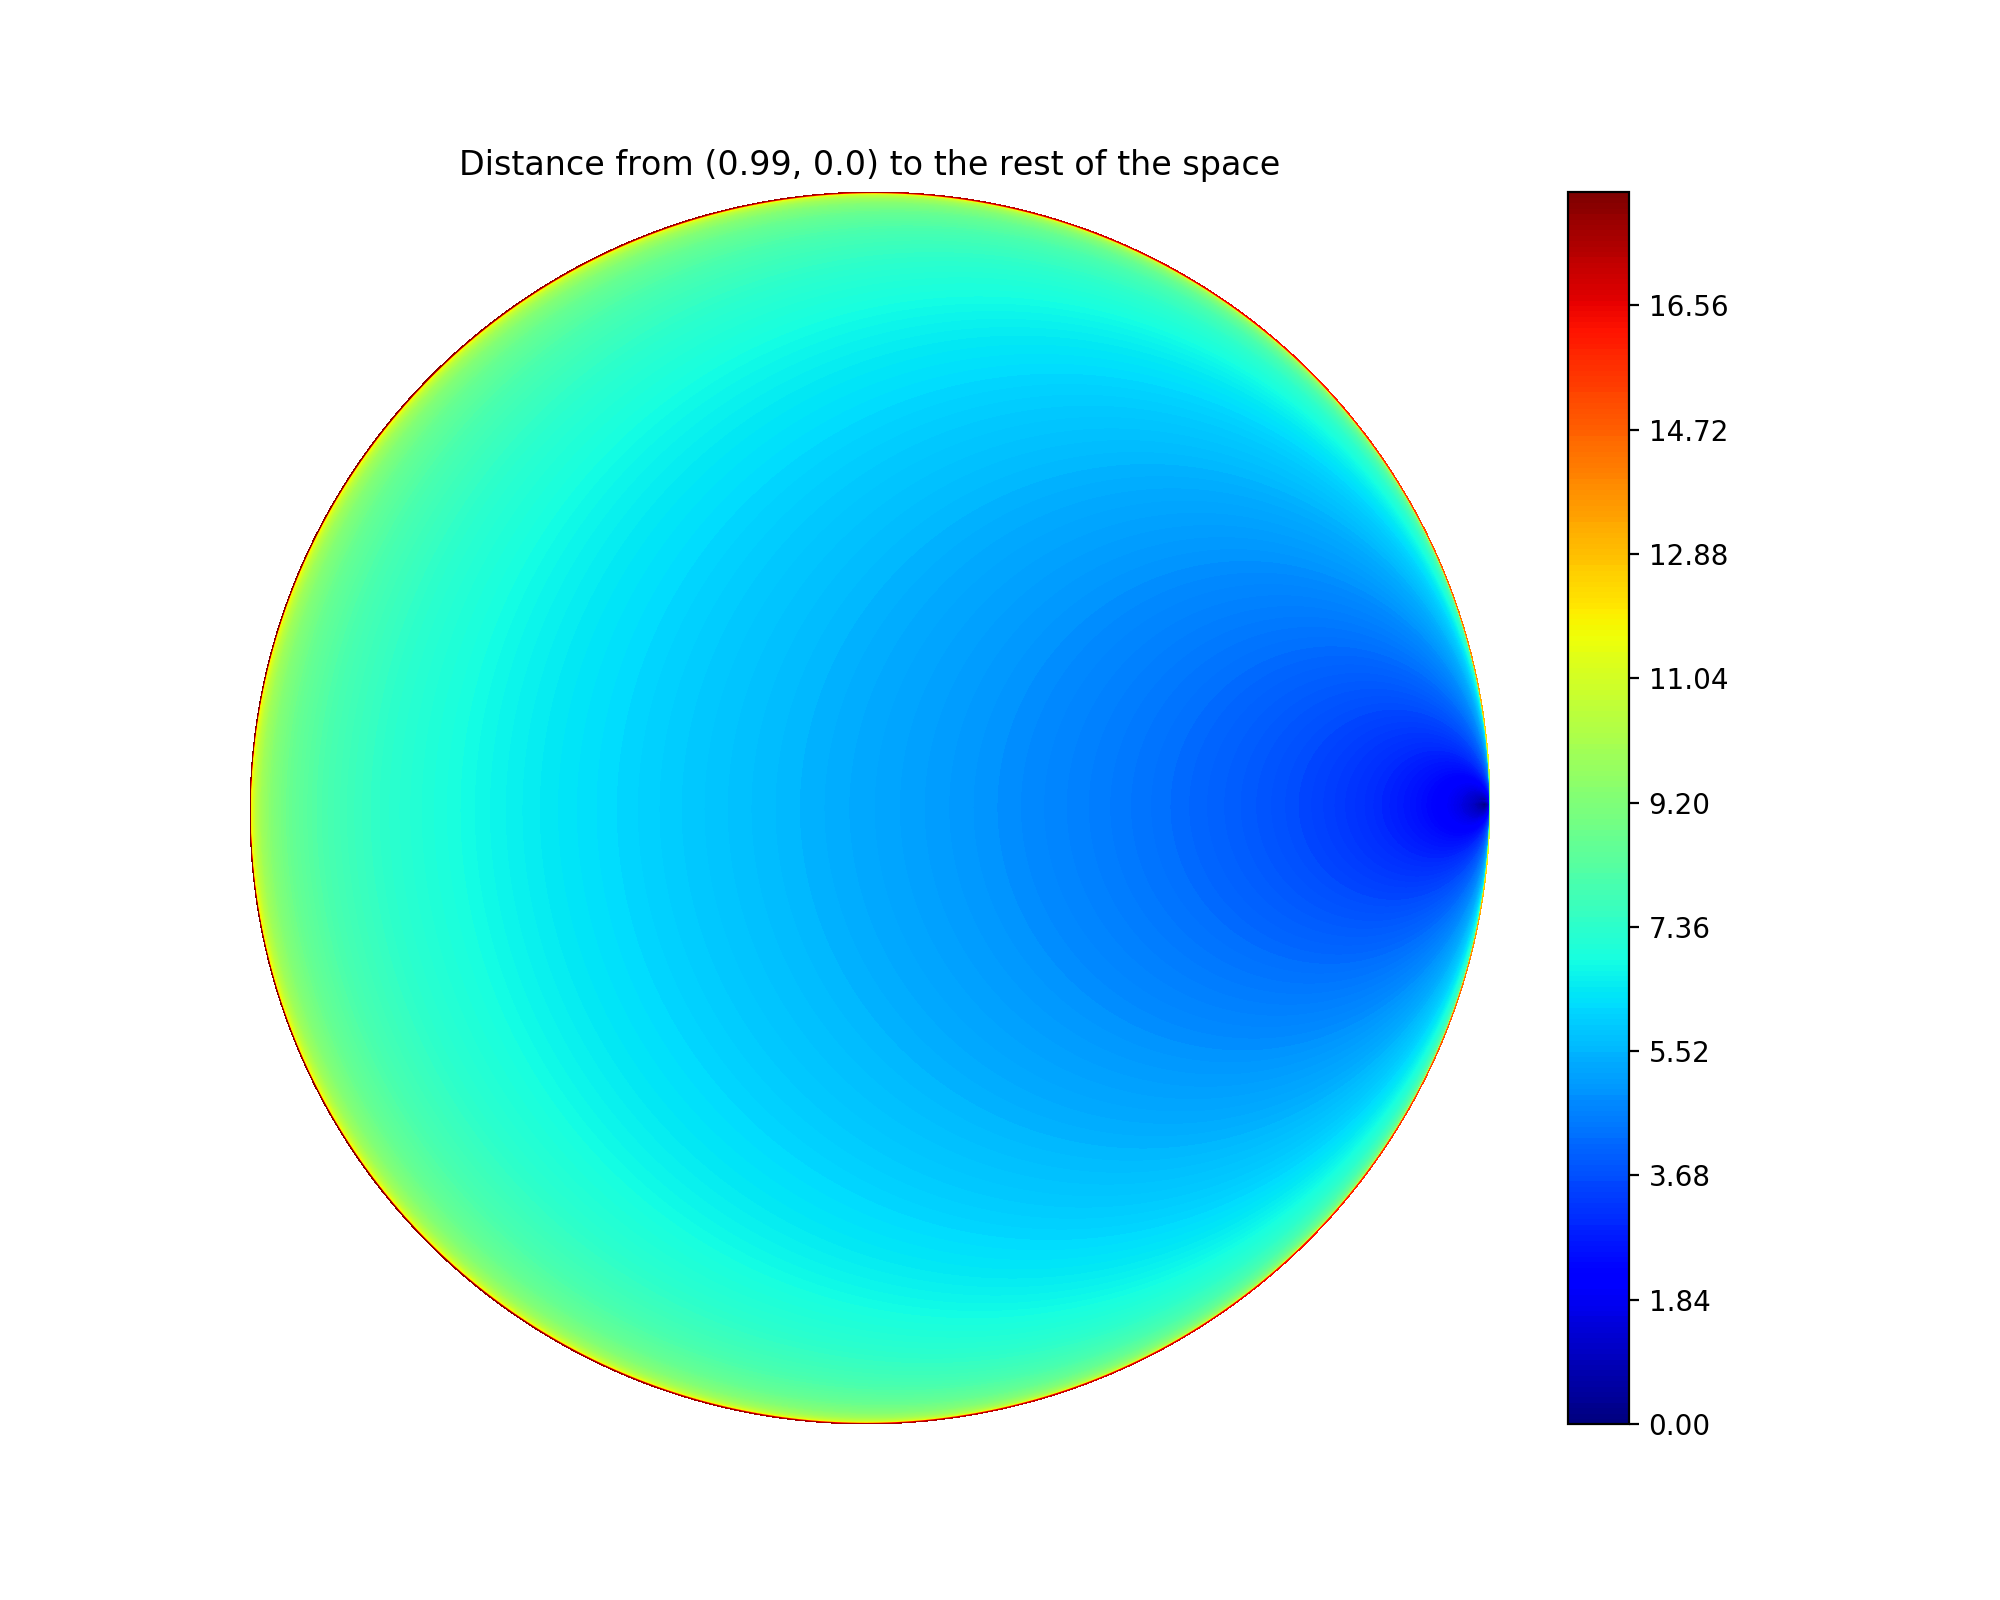

In [80]:
# Save vis of point at edge of space
p = [0.99 * np.cos(0), 0.99 * np.sin(0)]
draw_heatmap(p, './media/distance_from_edge.png', title="Distance from (0.99, 0.0) to the rest of the space")

<IPython.core.display.Javascript object>


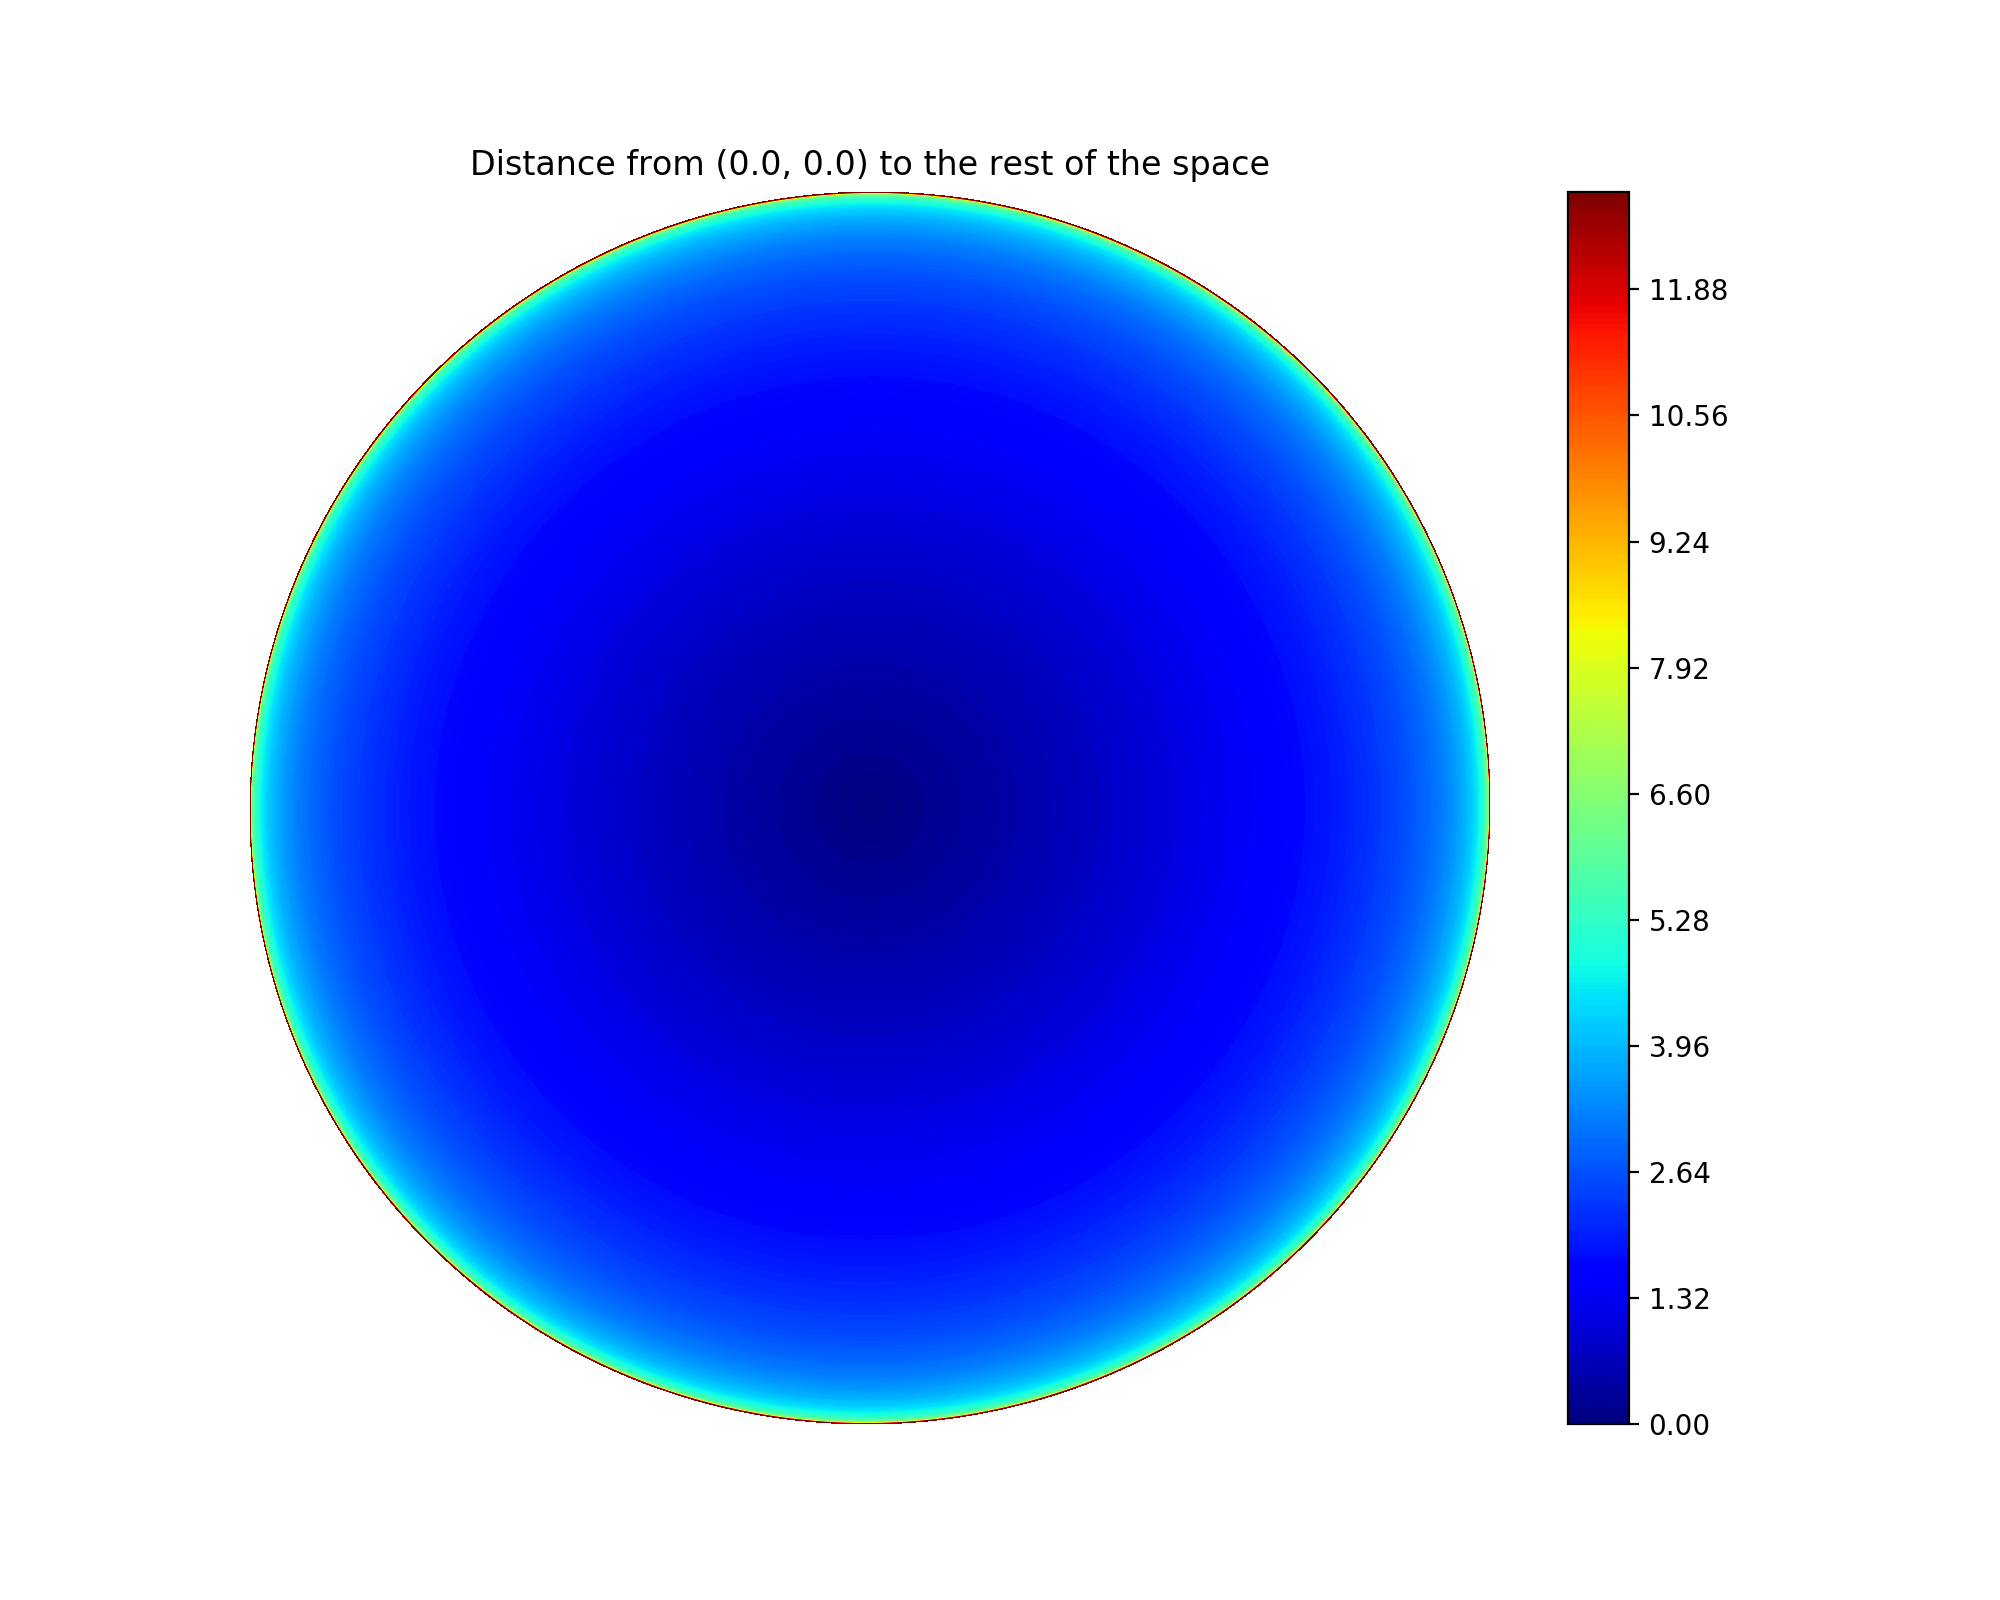

In [81]:
# Save vis of point at center of space
p = [0., 0.]
draw_heatmap(p, './media/distance_from_center.png', title="Distance from (0.0, 0.0) to the rest of the space")